In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Construct the file path
file_name = "ESM21.csv"

# Define column names
column_names = ['Time','Open', 'High', 'Low', 'Close','Volumes']

# Load the CSV file into a pandas DataFrame
data1 = pd.read_csv(file_name, names=column_names)

data1.tail()


,Time,Open,High,Low,Close,Volumes
119895,2021.06.18.09:25:00,4190.75,4193.50,4190.75,4191.25,176
119896,2021.06.18.09:26:00,4191.25,4191.50,4190.50,4190.50,26
119897,2021.06.18.09:27:00,4190.50,4191.50,4188.75,4190.00,192
119898,2021.06.18.09:28:00,4190.00,4191.00,4188.25,4189.75,177
119899,2021.06.18.09:29:00,4189.50,4189.75,4185.00,4185.50,454


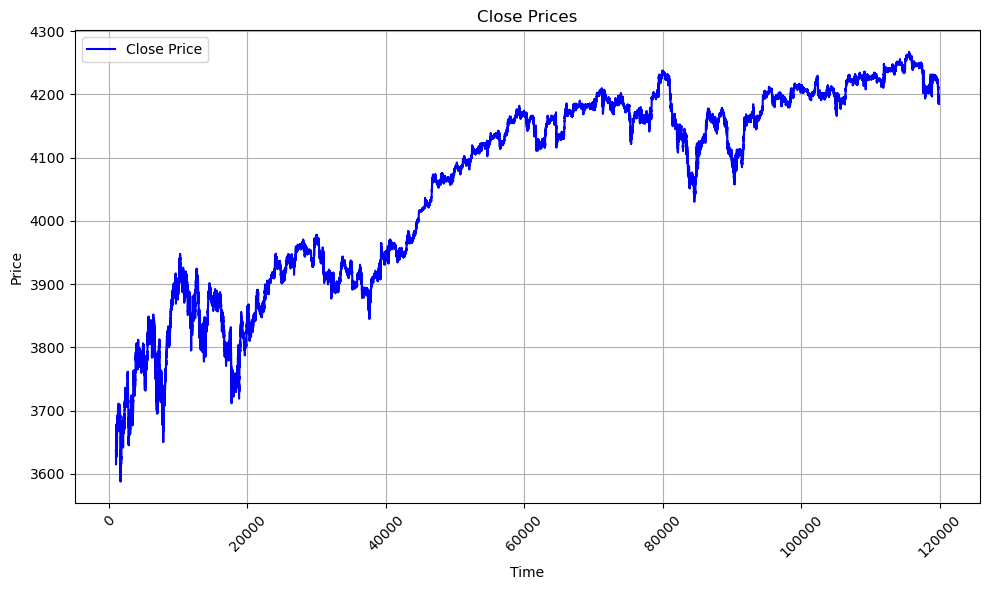

In [4]:
# Plot the Close prices with Time on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(data1[1000:]['Close'], label='Close Price', color='blue')
plt.title('Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [128]:
# Set pandas display options to show all rows without compression
pd.set_option('display.max_rows', None)

# Print the first 200 Close prices
first_200_close_prices = data1['Close'].head(1000)
#print(first_200_close_prices)


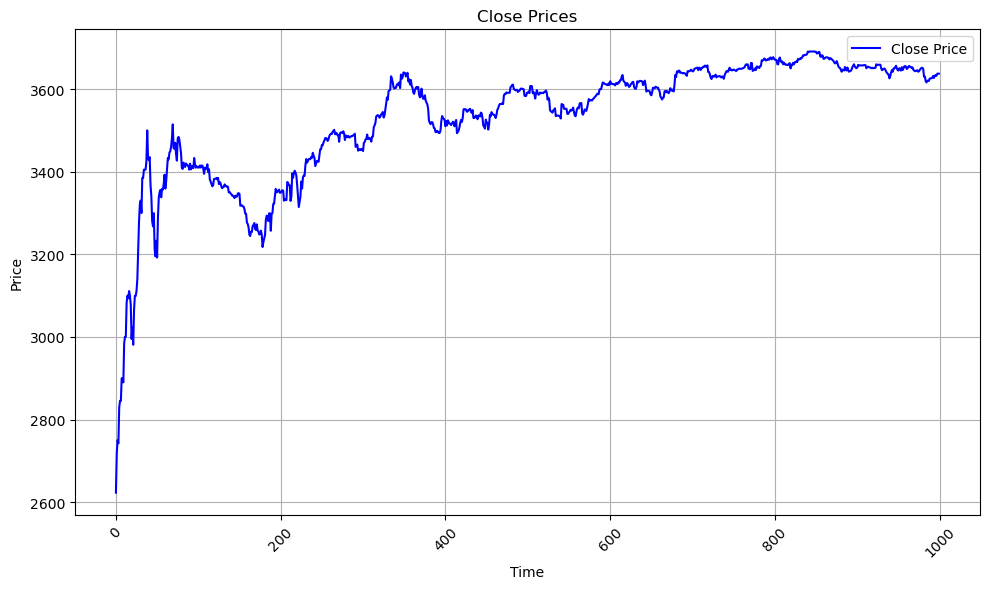

In [4]:
# Plot the Close prices with Time on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(first_200_close_prices, label='Close Price', color='blue')
plt.title('Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Trasformer

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

## 1. Helper Classes

In [281]:
class ETL:
    """
    data: pd.Series containing close prices
    test_size: float between 0 and 1
    n_input: int
    timestep: int
    Extracts data from the provided series,
    splits the data into train and test sets,
    reshapes the data into np.array of shape [#samples, timestep, 1],
    converts the problem into a supervised learning problem.
    """
    def __init__(self, data, test_size=0.2, n_input=5, timestep=1) -> None:
        self.data = data
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def split_data(self) -> tuple:
        """
        Splits the provided pd.Series into train and test series
        with the test series representing test_size * 100 % of data.
        """
        data = self.data
        train_idx = round(len(data) * (1 - self.test_size))
        train = data[:train_idx]
        test = data[train_idx:]
        return train.values.reshape(-1, 1), test.values.reshape(-1, 1)

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into the shape our model needs,
        namely, [#samples, timestep, 1].
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> tuple:
        """
        Reshapes the train and test sets into the required format.
        """
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple:
        """
        Runs complete ETL process.
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, data, n_out=1) -> tuple:
        """
        Converts the time series prediction problem to a
        supervised learning problem.
        """
        X, y = [], []
        # Step over the entire history one time step at a time
        for i in range(len(data) - self.n_input - n_out + 1):
            X.append(data[i:i + self.n_input])
            y.append(data[i + self.n_input:i + self.n_input + n_out])
        return np.array(X), np.array(y)




In [282]:
# Assuming 'data' is a pandas DataFrame containing the ESM21.csv data
data2=data1[10000:20000]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Correctly reshape the 'Close' column to a 2D numpy array before scaling
#data_scaled = scaler.fit_transform(data2['Close'].values.reshape(-1, 1))

# Convert the scaled data back into a pandas DataFrame, if needed
#data2_scaled_df = pd.DataFrame(data_scaled, columns=['Close_scaled'])

# If your ETL class expects a 1D array (as indicated by your use of .flatten()), 
# and you want to keep using the DataFrame structure in ETL,
# ensure that you pass the correctly formatted data
data = ETL(data2['Close'])

In [283]:
class PredictAndForecast:
    def __init__(self, model, train, test, n_input):
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given the last observations, forecasts the next price (1-step ahead).
        """
        # Flatten data and retrieve last observations for input
        data = np.array(history).reshape((len(history), -1))
        input_x = data[-self.n_input:, :].reshape((1, self.n_input, data.shape[1]))
        
        # Forecast the next step
        yhat = self.model.predict(input_x, verbose=0)[0]
        
        # Return only the first step of the prediction
        return yhat[0]  # Assuming yhat is shaped (n_outputs,) and we want the 1st output

    def get_predictions(self):
        """
        Generates predictions for the entire test set without applying scaling.
        """
        history = [x for x in self.train]
        predictions = []
        for i in range(len(self.test)):
            yhat = self.forecast(history)
            predictions.append(yhat)
            # Update history with actual test data for next prediction
            history.append(self.test[i, :])
        return np.array(predictions)  # Return predictions as is, without scaling


In [284]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

## 2. Implementing an LSTM baseline

In [285]:
def build_lstm(etl: ETL, epochs=25, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits our LSTM baseline model.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 1
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs))
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
  print('fitting model...')
  start = time.time()
  history = model.fit(etl.X_train, etl.y_train, batch_size=batch_size, epochs=epochs, validation_data=(etl.X_test, etl.y_test), verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return model, history

In [286]:
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/25
250/250 [==============================] - 3s 7ms/step - loss: 438126.0312 - mae: 229.4044 - mape: 5.9574 - val_loss: 43.6142 - val_mae: 4.5068 - val_mape: 0.1190
Epoch 2/25
250/250 [==============================] - 1s 6ms/step - loss: 3912.4558 - mae: 48.9774 - mape: 1.2732 - val_loss: 51.6565 - val_mae: 5.2489 - val_mape: 0.1385
Epoch 3/25
250/250 [==============================] - 2s 6ms/step - loss: 3919.8164 - mae: 49.0918 - mape: 1.2762 - val_loss: 41.8856 - val_mae: 4.3308 - val_mape: 0.1143
Epoch 4/25
250/250 [==============================] - 1s 6ms/step - loss: 3923.0945 - mae: 49.1280 - mape: 1.2771 - val_loss: 41.3996 - val_mae: 4.2826 - val_mape: 0.1131
Epoch 5/25
250/250 [==============================] - 1s 6ms/step - loss: 3940.8396 - mae: 49.1519 - mape: 1.2777 - val_loss: 48.8138 - val_mae: 4.9996 - val_mape: 0.1319
Epoch 6/25
250/250 [==============================] - 2s 6ms/step - loss: 3914.3779 - mae: 48.991

In [287]:
baseline_model = baseline[0]
history = baseline[1]

In [288]:
baseline_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200)               161600    
                                                                 
 dense_50 (Dense)            (None, 50)                10050     
                                                                 
 dense_51 (Dense)            (None, 1)                 51        
                                                                 
Total params: 171701 (670.71 KB)
Trainable params: 171701 (670.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Implementing a Transformer

In [289]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):

  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):

  n_timesteps, n_features, n_outputs = 5, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [290]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [291]:
transformer.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_104 (L  (None, 5, 1)                 2         ['input_14[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_52 (M  (None, 5, 1)                 3585      ['layer_normalization_104[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

 dropout_122 (Dropout)       (None, 5, 2)                 0         ['conv1d_108[0][0]']          
                                                                                                  
 conv1d_109 (Conv1D)         (None, 5, 1)                 3         ['dropout_122[0][0]']         
                                                                                                  
 tf.__operators__.add_109 (  (None, 5, 1)                 0         ['conv1d_109[0][0]',          
 TFOpLambda)                                                         'tf.__operators__.add_108[0][
                                                                    0]']                          
                                                                                                  
 layer_normalization_110 (L  (None, 5, 1)                 2         ['tf.__operators__.add_109[0][
 ayerNormalization)                                                 0]']                          
          

In [292]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist


In [293]:
hist = fit_transformer(transformer)

Epoch 1/25
250/250 [==============================] - 9s 13ms/step - loss: 369186.3438 - mae: 357.1671 - mape: 9.2673
Epoch 2/25
250/250 [==============================] - 3s 13ms/step - loss: 70680.4141 - mae: 210.3892 - mape: 5.4600
Epoch 3/25
250/250 [==============================] - 3s 13ms/step - loss: 54796.5859 - mae: 186.5870 - mape: 4.8424
Epoch 4/25
250/250 [==============================] - 3s 12ms/step - loss: 42376.1562 - mae: 164.0166 - mape: 4.2568
Epoch 5/25
250/250 [==============================] - 3s 13ms/step - loss: 35892.1094 - mae: 150.9082 - mape: 3.9166
Epoch 6/25
250/250 [==============================] - 3s 13ms/step - loss: 29645.4570 - mae: 137.2357 - mape: 3.5618
Epoch 7/25
250/250 [==============================] - 3s 13ms/step - loss: 26934.4941 - mae: 131.0789 - mape: 3.4019
Epoch 8/25
250/250 [==============================] - 3s 13ms/step - loss: 27379.8535 - mae: 131.7933 - mape: 3.4207
Epoch 9/25
250/250 [==============================] - 3s 13ms/s

### Inference on our Models

In [295]:
start = time.time()
# Note: No scaler argument is passed here, assuming it was removed from the class definition
baseline_preds = PredictAndForecast(baseline_model, data.train, data.test, n_input=5).predictions
print(time.time() - start)


120.96790075302124


In [296]:
start = time.time()
transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5).predictions
print(time.time() - start)

128.8878448009491


In [297]:
# Assume data.test is your test dataset and transformer_preds.predictions are your model predictions
transformer_preds# Before using Evaluate, ensure the shapes align or adjust the prediction generation logic
# e.g., Ensure transformer_preds.predictions generates predictions that match data.test in shape

# If there's a shape mismatch, adjust the forecasting logic in PredictAndForecast to ensure consistency


array([3734.009 , 3734.406 , 3734.603 , ..., 3868.0596, 3869.4685,
       3870.1611], dtype=float32)

# 4. Evaluating on test set

In [298]:
# Correcting the evaluation step
baseline_evals = Evaluate(data.test, baseline_preds)
transformer_evals = Evaluate(data.test, transformer_preds)




In [299]:
baseline_evals.mape, transformer_evals.mape

(0.0006526977557102, 0.002388467687591378)

In [300]:
baseline_evals.var_ratio, transformer_evals.var_ratio

(0.00610359036088326, 0.0015018596686287022)

# 5. Visualizing

In [303]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='Stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green, over time.
    """
    # Ensure that 'test' and 'preds' are numpy arrays and correctly shaped for plotting
    if test.ndim == 3:  # If test data is [samples, timesteps, features]
        test = test[:, -1, 0]  # Selecting the last timestep and first feature for each sample
    if preds.ndim > 2:
        preds = preds[:, 0]  # Assuming preds is [samples, features] and we need the first feature
    
    # Ensure 'df' has an index that represents the time series, adjusting here if necessary
    # For illustration, assuming 'df' is your original dataframe and its index is dates
    # Adjust 'x' calculation if 'df' structure is different
    x = df.index[-len(test):]  # This assumes the index of 'df' is date or time
    
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(x, test, label='Actual', color='red')
    ax.plot(x, preds, label='Predictions', color='green')
    
    if title_suffix is None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    
    if image_path is not None:
        # Update the path as per your directory structure or keep it as is if '/mnt/data' works for you
        plt.savefig(f'/mnt/data/{image_path}.png')
    
    plt.show()


In [247]:
data.test

array([[[0.06455026]],

       [[0.06984127]],

       [[0.07830688]],

       ...,

       [[0.63703704]],

       [[0.63703704]],

       [[0.63280423]]])

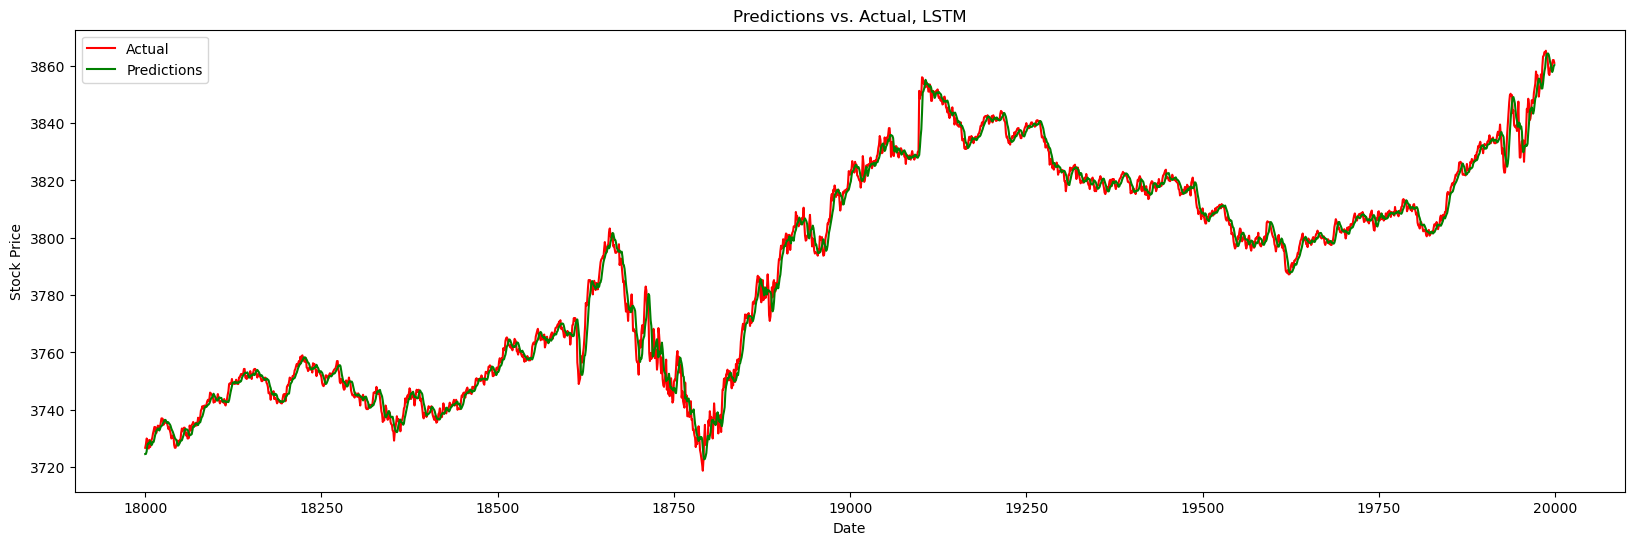

In [304]:
# Make sure 'scaler' is the MinMaxScaler instance you used to scale your data
plot_results(data.test, baseline_preds, data2, title_suffix='LSTM')


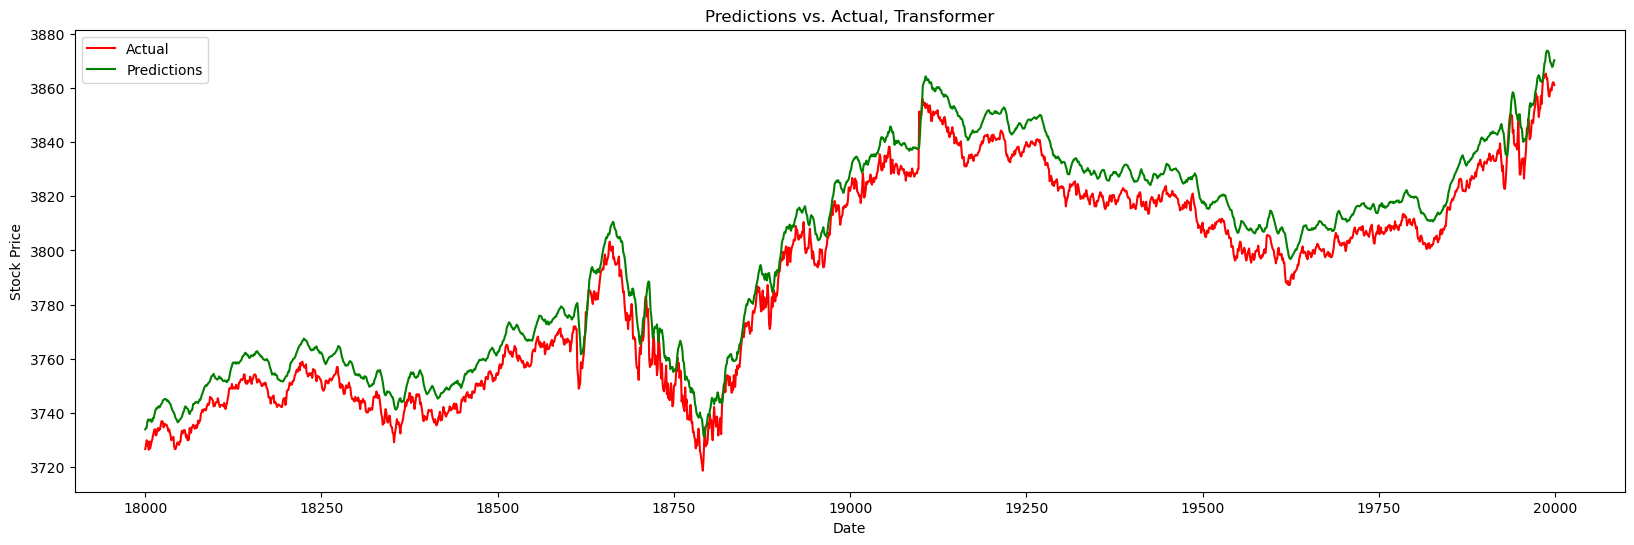

In [305]:
plot_results(data.test, transformer_preds, data2, title_suffix='Transformer')